This notebook shows examples on the coupled SIA/SSA model with fully rate-and-state-friction-drainage. It also contains a few simple examples on how to read data stored with the hdf5 format

In [1]:
import pyGlacier as pg
import matplotlib.pyplot as plt
import numpy as np
import os
import tables as tb

In [2]:
# Initialize flowline glacier
x = np.linspace(0,2e4,1000)
dx = x[1]-x[0]
b = 2000.0*np.exp(-x/15000)

def SMB(model):
    return (model.b+model.H-1600.0)*1e-3/(3.15e7)*4

def source_term(model):
    return 2.0e-8*(np.sin(model.t*3.14/3.15e7)**2.0)

# Set up variable dictionary:
variables = {
'solver': 
    {'ID': 'coupled',
    'variables':{
        'SMB': SMB,
        'rho': 900.0,
        'g': 9.8,
        'n': 3.0,
        'width': 1.5e3,
        't': 0.0,
        'A': 2.4e-24,
        'H': 0*x,
        'b': b,
        'dx': dx},
    'boundaryConditions':{
        'left':{
            'type': 'surface slope',
            'val': 0},
        'right':{
            'type': 'thickness',
            'val': 0} } },
'DrainageSystem': 
    {'ID': 'CoupledConduitCavitySheet',
    'variables': {
        'hydraulic_potential':1000.0*9.8*b, #Set initial hydraulic potential based on topography
        'latent_heat': 3.0e5,
        'source_term': source_term,
        'water_density': 1000.0,
        'minimum_drainage_thickness': 1.0, # Minimum thickness for when to invoke drainage system (water pressure will not rise above 0 below this thickness)
        'S': 0*b, #Initial conduit size
        'ev': 1.0e-2,
        'percolation_threshold': 0.5,
        'geothermal_heat_flux': 0.0,
        'h0': 0.1,
        'background_conductivity': 1.0e-8,
        'sheet_conductivity': 5.0e-8,
        'channel_constant': 0.003,
        'conduit_spacing': 1000.0,
        'closure_coefficient': 1.0e8 } },
'FrictionLaw': 
    {'ID': 'HardBed_RSF',
     'variables':{ 
        'state_parameter': np.ones(np.size(b)),
        'As': 1.0e-23,
        'm': 3.0,
        'q': 2.5,
        'C': 0.4,
        'tc': 1.0e6,
        'dc': 1.0,
        't_closure_zero_thickness': 1.0e5 } },
'Output': 
    {'ID': 'standard',
    'foldername': 'dataFromExamples/coupledModel', # By design, the simulation will raise an exeption if this folder exists. This is done to avoid overwriting data if using an existing run-name. The folder 'dataFromExamples needs to exist'
    'output_interval': 30, #will give around 100 time steps per year output
    'reduced': True, # Outputs averaged and min/max quantities over the glacier
    'reduced_output_interval': 10, # Higher resolution average output
    'flush_interval': 10000,
    'file_format': 'hdf5'} }

standard
********** INITIALIZING FLOWLINE **********
Solver: coupled
FrictionLaw: HardBed_RSF
DrainageSystem: CoupledConduitCavitySheet
*******************************************
********** INITIALIZE SIA **********
********** RUN **********
t max: 299.45242984257357 years
dt:100000.0 s
**************************
0.9981747661419119 years, dt = 100000.0s
1.9963495322838238 years, dt = 100000.0s
2.994524298425736 years, dt = 100000.0s
3.9926990645676477 years, dt = 100000.0s
4.9908738307095595 years, dt = 100000.0s
5.989048596851472 years, dt = 100000.0s
6.987223362993383 years, dt = 100000.0s
7.985398129135295 years, dt = 100000.0s
8.983572895277208 years, dt = 100000.0s
9.981747661419119 years, dt = 100000.0s
10.979922427561032 years, dt = 100000.0s
11.978097193702943 years, dt = 100000.0s
12.976271959844855 years, dt = 100000.0s
13.974446725986766 years, dt = 100000.0s
14.97262149212868 years, dt = 100000.0s
15.97079625827059 years, dt = 100000.0s
16.968971024412504 years, dt = 10000

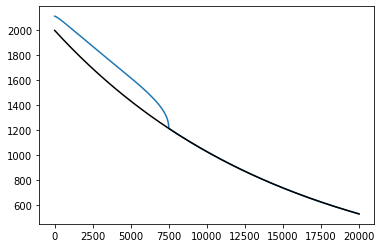

In [3]:
glacier = pg.Flowline(variables = variables)
glacier.runInitializeSIA(dt = 1e5, t_max = 300*3.15e7) # Start simulation with 300 years of SIA

plt.figure()
plt.plot(glacier.x,glacier.H+glacier.b)
plt.plot(glacier.x,glacier.b,'k')
plt.show()

In [4]:
glacier.runAdaptive(t_max = 200*pg.secondyears, dt_min = 10, dt_max = 1e4, error_tolerance = 1e-3, interval = 10) # 200 year simulation

********** RUN ADAPTIVE **********
t max: 200.0 years
dt in [10,10000.0] s
error tolerance: 0.001
**********************************
2.7563638427668806 years, dt = 10000.0s, rel_error = 8.357756037520712e-05
5.765413428762024 years, dt = 10000.0s, rel_error = 9.168129646012093e-05
8.613478839744124 years, dt = 10000.0s, rel_error = 3.2475785943937085e-05
11.725939686101267 years, dt = 10000.0s, rel_error = 0.00020218105239318165
14.697185383334283 years, dt = 10000.0s, rel_error = 4.879202366588345e-05
17.54833864513873 years, dt = 10000.0s, rel_error = 0.00010310673575526207
20.69565638809127 years, dt = 10000.0s, rel_error = 5.7097731386179667e-05
23.676114519796805 years, dt = 10000.0s, rel_error = 8.735442221561786e-05
26.706049599693856 years, dt = 10000.0s, rel_error = 0.0005939119394499779
29.853367342646393 years, dt = 10000.0s, rel_error = 7.372586581568911e-05
32.79664608421727 years, dt = 10000.0s, rel_error = 6.712653359480821e-05
35.84824136443501 years, dt = 10000.0s, rel

0

Now that the run has finished, we can open the file. The default location is "yourFoldername/data/out.h5", which is split in data.root.INIT, data.root.full and data.root.average

There is also an src folder created where the run script is copied. Note that this particular feature is currently not compatible with the use of jupyter.

In [5]:
data = tb.open_file(variables['Output']['foldername'] + '/data/out.h5')
x = [x/1000 for x in data.root.INIT.x]
t = [x/pg.secondyears for x in data.root.full.t]
t_ave = [x/pg.secondyears for x in data.root.average.t]
H = [x for x in data.root.full.H]
H_ave = [x for x in data.root.average.H]
U = [x*pg.secondyears  for x in data.root.full.U]
U_SSA = [x*pg.secondyears  for x in data.root.full.U_SSA]
U_SIA = [x*pg.secondyears  for x in data.root.full.U_SIA]
sliding_velocity = [x*pg.secondyears  for x in data.root.full.sliding_velocity]
U_ave = [x*pg.secondyears for x in data.root.average.U]
pw = [x/1e6 for x in data.root.full.water_pressure]
pw_ave = [x/1e6 for x in data.root.average.water_pressure]
theta = [x for x in data.root.full.state_parameter]
theta_ave = [x for x in data.root.average.state_parameter]
S_ave = [x for x in data.root.average.S]
S = [x for x in data.root.full.S]

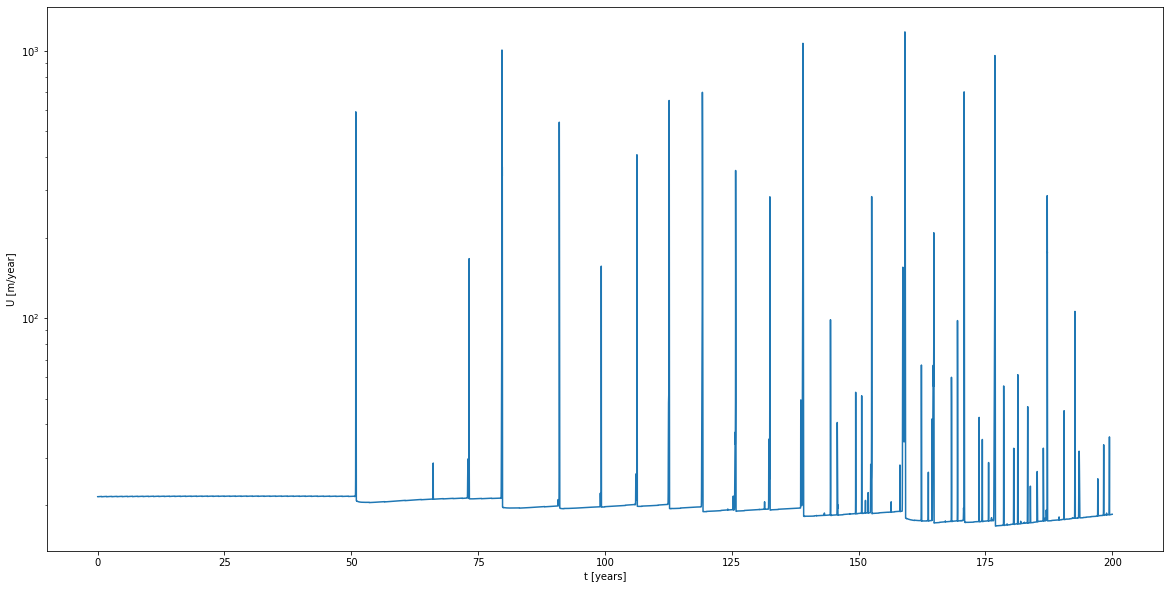

In [6]:
plt.figure(figsize = (20,10))
plt.plot(t_ave,U_ave)
plt.yscale('log')
plt.xlabel('t [years]')
plt.ylabel('U [m/year]')
plt.show()

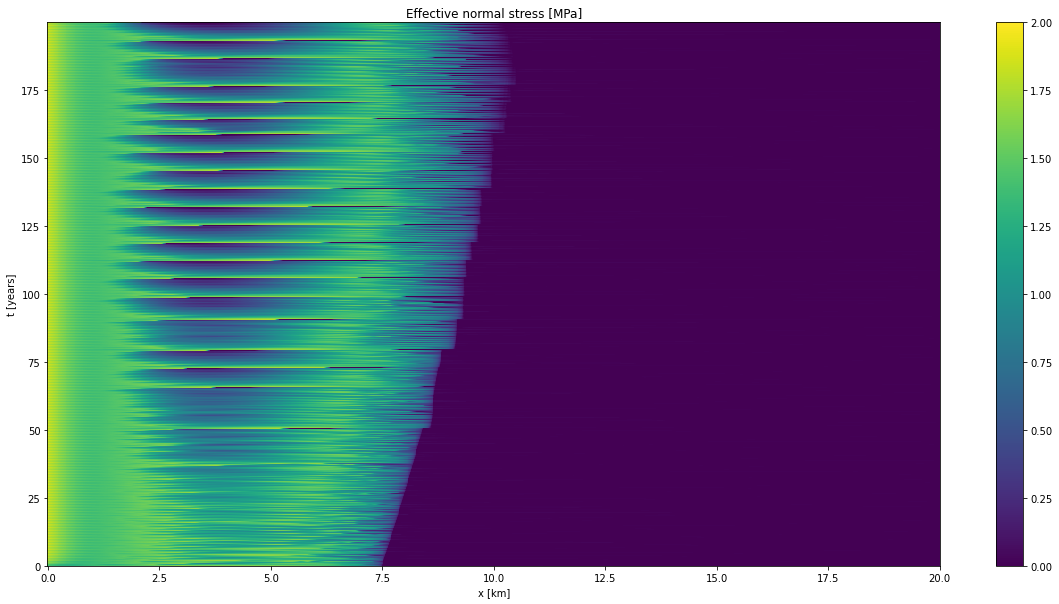

In [7]:
plt.figure(figsize = (20,10))
plt.pcolormesh(x,t,9.8*900*np.array(H)/1e6-np.array(pw),shading='auto')
plt.clim([0,2])
plt.colorbar()
plt.title('Effective normal stress [MPa]')
plt.xlabel('x [km]')
plt.ylabel('t [years]')
plt.show()

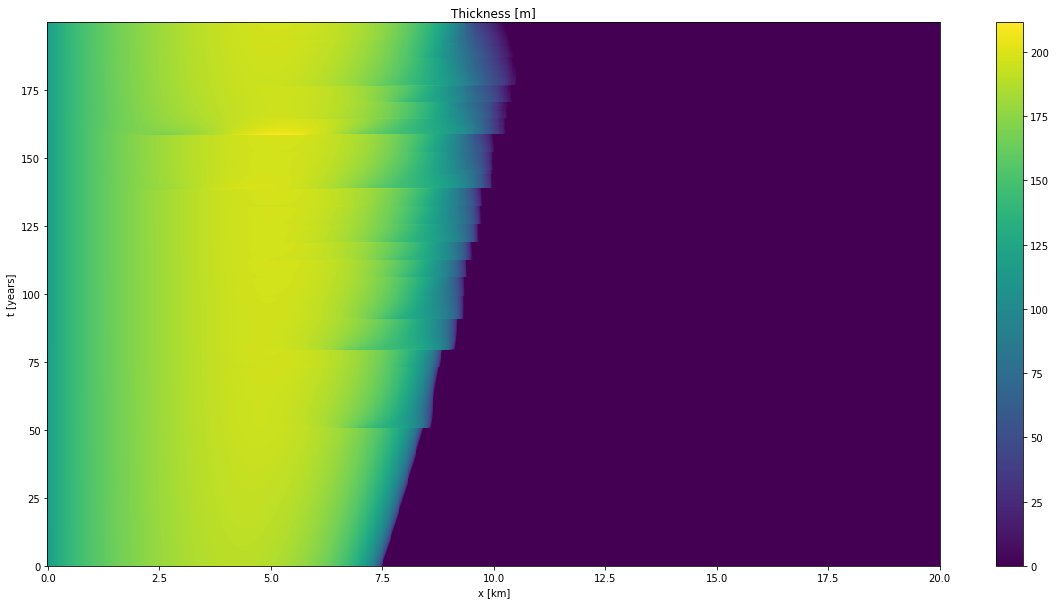

In [8]:
plt.figure(figsize = (20,10))
plt.pcolormesh(x,t,np.array(H),shading='auto')
plt.colorbar()
plt.title('Thickness [m]')
plt.xlabel('x [km]')
plt.ylabel('t [years]')
plt.show()